In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# Define the exact solution u = H
def exact_solution_u(x, t):
    return torch.sin(x)*torch.cos(t)

def initial_condition_u(x):
    return torch.sin(x) 

In [3]:
# Define the exact solution p = E
def exact_solution_p(x, t):
    return -torch.sin(t)*torch.cos(x)

def initial_condition_p(x):
    return 0.0*torch.sin(x) 

In [4]:
# assigning number of points
initial_pts = 2000
left_boundary_pts = 2000 
right_boundary_pts = 2000
residual_pts = 10000

In [5]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1)
w_init = torch.cat([u_init, p_init],1)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, tb_left ],1)
u_b_l = exact_solution_u(xb_left, tb_left)
p_b_l = exact_solution_p(xb_left, tb_left)
w_b_l = torch.cat([u_b_l, p_b_l],1)



xb_right = pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1)
u_b_r = exact_solution_u(xb_right, tb_right)
p_b_r = exact_solution_p(xb_right, tb_right)
w_b_r = torch.cat([u_b_r, p_b_r],1)

x_interior = pi*torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, w_init, b_left,  b_right), batch_size=2000, shuffle=False)

In [6]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [7]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = w_init.shape[1], n_hidden_layers=4, neurons=20)


In [8]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
#print(my_network(init))

In [9]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [10]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, w_initial, bd_left,  bd_right) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:,0].reshape(-1,1)
                p_initial_pred_ = w_initial_pred_[:,1].reshape(-1,1)
                
                
                # with derivative
                inpu = torch.ones(initial_pts, 1 )
                
                grad_u_ini = torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                
                u_initial_t = grad_u_ini[:, 1]
                
                
                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]
                
                p_initial_t = grad_p_ini[:, 1]
                
                
                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:,0].reshape(-1,1)
                p_bd_left_pred_ = w_bd_left_pred_[:,1].reshape(-1,1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:,0].reshape(-1,1)
                p_bd_right_pred_ = w_bd_right_pred_[:,1].reshape(-1,1)
                
                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:,0].reshape(-1,1)
                p_hat = w_hat[:,1].reshape(-1,1)
                inputs = torch.ones(residual_pts, 1 )
                inputs2 = torch.ones(residual_pts, 1)
                grad_u_hat = torch.autograd.grad(u_hat.reshape(-1,1), interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_x = grad_u_hat[:, 0].reshape(-1,1)
                
               
                
                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                
                p_x = grad_p_hat[:, 0].reshape(-1,1)
                
              
               
                
                
                #grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                #u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1,1)
                
               
                
                p_t = grad_p_hat[:,1].reshape(-1,1)
             
                
                
                
                # Item 1. below
                loss1 = torch.mean((u_initial_pred_.reshape(-1, ) - w_initial[:,0].reshape(-1, ))**p) + 0.01*torch.mean((u_t.reshape(-1, ) + p_x.reshape(-1, ))**p)+torch.mean((u_bd_left_pred_.reshape(-1,)- u_b_l.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,)- u_b_r.reshape(-1,))**p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:,1].reshape(-1, ))**p)+ torch.mean((2*p_t.reshape(-1, )  + torch.sin(interior[:, 0]).reshape(-1, ) + u_x.reshape(-1, ) + torch.cos(interior[:, 0])*torch.cos(interior[:, 1])-torch.sin(interior[:, 0]))**p)+torch.mean((p_bd_left_pred_.reshape(-1,) - p_b_l.reshape(-1,))**p) + torch.mean((p_bd_right_pred_.reshape(-1,)- p_b_r.reshape(-1,))**p)
                loss = loss1 + loss2
                    #loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))

                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [11]:
n_epochs = 2500
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  7.649980545043945
################################  1  ################################
Loss:  7.429339408874512
################################  2  ################################
Loss:  6.018902778625488
################################  3  ################################
Loss:  4.880969047546387
################################  4  ################################
Loss:  4.087650775909424
################################  5  ################################
Loss:  3.46986722946167
################################  6  ################################
Loss:  2.95176362991333
################################  7  ################################
Loss:  2.510434865951538
################################  8  ################################
Loss:  2.1389217376708984
################################  9  ################################
Loss:  1.8322559595108032
################################  10  ############

Loss:  0.008761725388467312
################################  89  ################################
Loss:  0.008451094850897789
################################  90  ################################
Loss:  0.008143783546984196
################################  91  ################################
Loss:  0.007846531458199024
################################  92  ################################
Loss:  0.0075866966508328915
################################  93  ################################
Loss:  0.007331333123147488
################################  94  ################################
Loss:  0.007092949002981186
################################  95  ################################
Loss:  0.006863156333565712
################################  96  ################################
Loss:  0.0066474853083491325
################################  97  ################################
Loss:  0.006443658843636513
################################  98  ################################
Loss:  0

Loss:  0.001068125944584608
################################  174  ################################
Loss:  0.0010553100146353245
################################  175  ################################
Loss:  0.0010429477551952004
################################  176  ################################
Loss:  0.0010308846831321716
################################  177  ################################
Loss:  0.0010188401211053133
################################  178  ################################
Loss:  0.0010066169779747725
################################  179  ################################
Loss:  0.0009940360905602574
################################  180  ################################
Loss:  0.0009807838359847665
################################  181  ################################
Loss:  0.0009669553255662322
################################  182  ################################
Loss:  0.0009519668528810143
################################  183  ########################

Loss:  0.0003007872146554291
################################  262  ################################
Loss:  0.0002935219672508538
################################  263  ################################
Loss:  0.00028657540678977966
################################  264  ################################
Loss:  0.0002797419438138604
################################  265  ################################
Loss:  0.00027343930560164154
################################  266  ################################
Loss:  0.0002672281116247177
################################  267  ################################
Loss:  0.000261270091868937
################################  268  ################################
Loss:  0.0002553829981479794
################################  269  ################################
Loss:  0.00024975091218948364
################################  270  ################################
Loss:  0.0002442762488499284
################################  271  #####################

Loss:  9.828379552345723e-05
################################  348  ################################
Loss:  9.776464139577001e-05
################################  349  ################################
Loss:  9.718592627905309e-05
################################  350  ################################
Loss:  9.674310422269627e-05
################################  351  ################################
Loss:  9.631002467358485e-05
################################  352  ################################
Loss:  9.577732271282002e-05
################################  353  ################################
Loss:  9.534570563118905e-05
################################  354  ################################
Loss:  9.488887008046731e-05
################################  355  ################################
Loss:  9.442308510188013e-05
################################  356  ################################
Loss:  9.384372242493555e-05
################################  357  #######################

Loss:  4.627864109352231e-05
################################  435  ################################
Loss:  4.615818033926189e-05
################################  436  ################################
Loss:  4.604184505296871e-05
################################  437  ################################
Loss:  4.592305049300194e-05
################################  438  ################################
Loss:  4.5805958507116884e-05
################################  439  ################################
Loss:  4.56853122159373e-05
################################  440  ################################
Loss:  4.556254134513438e-05
################################  441  ################################
Loss:  4.543157047010027e-05
################################  442  ################################
Loss:  4.531354352366179e-05
################################  443  ################################
Loss:  4.5165132178226486e-05
################################  444  ######################

Loss:  3.147306415485218e-05
################################  520  ################################
Loss:  3.13573436869774e-05
################################  521  ################################
Loss:  3.124547947663814e-05
################################  522  ################################
Loss:  3.113557249889709e-05
################################  523  ################################
Loss:  3.102761911577545e-05
################################  524  ################################
Loss:  3.092155384365469e-05
################################  525  ################################
Loss:  3.0815648642601445e-05
################################  526  ################################
Loss:  3.071413084398955e-05
################################  527  ################################
Loss:  3.061204552068375e-05
################################  528  ################################
Loss:  3.0508386771543883e-05
################################  529  ######################

Loss:  2.3788546968717128e-05
################################  606  ################################
Loss:  2.370299625908956e-05
################################  607  ################################
Loss:  2.3613349185325205e-05
################################  608  ################################
Loss:  2.352689261897467e-05
################################  609  ################################
Loss:  2.343705273233354e-05
################################  610  ################################
Loss:  2.3337001039180905e-05
################################  611  ################################
Loss:  2.3236605557030998e-05
################################  612  ################################
Loss:  2.3119533580029383e-05
################################  613  ################################
Loss:  2.301775020896457e-05
################################  614  ################################
Loss:  2.2868467567604966e-05
################################  615  #################

Loss:  1.610553590580821e-05
################################  692  ################################
Loss:  1.6037858586059883e-05
################################  693  ################################
Loss:  1.5985811842256226e-05
################################  694  ################################
Loss:  1.5926176274660975e-05
################################  695  ################################
Loss:  1.5874791643000208e-05
################################  696  ################################
Loss:  1.582476033945568e-05
################################  697  ################################
Loss:  1.5770898244227283e-05
################################  698  ################################
Loss:  1.5718936992925592e-05
################################  699  ################################
Loss:  1.5669866115786135e-05
################################  700  ################################
Loss:  1.5623496437910944e-05
################################  701  ###############

Loss:  1.3431837032840122e-05
################################  775  ################################
Loss:  1.3400001989793964e-05
################################  776  ################################
Loss:  1.336798413831275e-05
################################  777  ################################
Loss:  1.3338423741515726e-05
################################  778  ################################
Loss:  1.3307480912772007e-05
################################  779  ################################
Loss:  1.3271108400658704e-05
################################  780  ################################
Loss:  1.3238708561402746e-05
################################  781  ################################
Loss:  1.3206025869294535e-05
################################  782  ################################
Loss:  1.3176791981095448e-05
################################  783  ################################
Loss:  1.3145086995791644e-05
################################  784  ##############

Loss:  1.0136473974853288e-05
################################  856  ################################
Loss:  1.0122492312802933e-05
################################  857  ################################
Loss:  1.0109626600751653e-05
################################  858  ################################
Loss:  1.0095769539475441e-05
################################  859  ################################
Loss:  1.0083394954563119e-05
################################  860  ################################
Loss:  1.0069885320262983e-05
################################  861  ################################
Loss:  1.0054713129648007e-05
################################  862  ################################
Loss:  1.0037892934633419e-05
################################  863  ################################
Loss:  1.0020852641901001e-05
################################  864  ################################
Loss:  1.0003193892771378e-05
################################  865  #############

Loss:  7.994378393050283e-06
################################  941  ################################
Loss:  7.980273949215189e-06
################################  942  ################################
Loss:  7.966973498696461e-06
################################  943  ################################
Loss:  7.95467167336028e-06
################################  944  ################################
Loss:  7.943175660329871e-06
################################  945  ################################
Loss:  7.932795597298536e-06
################################  946  ################################
Loss:  7.922925760794897e-06
################################  947  ################################
Loss:  7.913638910395093e-06
################################  948  ################################
Loss:  7.904272933956236e-06
################################  949  ################################
Loss:  7.894643204053864e-06
################################  950  ########################

Loss:  7.347251084866002e-06
################################  1028  ################################
Loss:  7.334943802561611e-06
################################  1029  ################################
Loss:  7.324955731746741e-06
################################  1030  ################################
Loss:  7.313527476071613e-06
################################  1031  ################################
Loss:  7.300743163796142e-06
################################  1032  ################################
Loss:  7.286717846000101e-06
################################  1033  ################################
Loss:  7.271507456607651e-06
################################  1034  ################################
Loss:  7.2553038990008645e-06
################################  1035  ################################
Loss:  7.23806533642346e-06
################################  1036  ################################
Loss:  7.219869075925089e-06
################################  1037  #############

Loss:  6.1605742303072475e-06
################################  1111  ################################
Loss:  6.151551588118309e-06
################################  1112  ################################
Loss:  6.142302481748629e-06
################################  1113  ################################
Loss:  6.132899216026999e-06
################################  1114  ################################
Loss:  6.123297225713031e-06
################################  1115  ################################
Loss:  6.113702966104029e-06
################################  1116  ################################
Loss:  6.105194188421592e-06
################################  1117  ################################
Loss:  6.097067853261251e-06
################################  1118  ################################
Loss:  6.088598183850991e-06
################################  1119  ################################
Loss:  6.080693310650531e-06
################################  1120  ############

Loss:  5.645129022013862e-06
################################  1192  ################################
Loss:  5.633079126710072e-06
################################  1193  ################################
Loss:  5.61949400434969e-06
################################  1194  ################################
Loss:  5.605397745966911e-06
################################  1195  ################################
Loss:  5.591863555309828e-06
################################  1196  ################################
Loss:  5.57789553568e-06
################################  1197  ################################
Loss:  5.56274198970641e-06
################################  1198  ################################
Loss:  5.548468379856786e-06
################################  1199  ################################
Loss:  5.533981493499596e-06
################################  1200  ################################
Loss:  5.5188579608511645e-06
################################  1201  ##################

Loss:  4.686497959482949e-06
################################  1278  ################################
Loss:  4.680099209508626e-06
################################  1279  ################################
Loss:  4.67389418190578e-06
################################  1280  ################################
Loss:  4.668381279770983e-06
################################  1281  ################################
Loss:  4.66337769466918e-06
################################  1282  ################################
Loss:  4.65865832666168e-06
################################  1283  ################################
Loss:  4.653866199078038e-06
################################  1284  ################################
Loss:  4.6496561481035315e-06
################################  1285  ################################
Loss:  4.645699846150819e-06
################################  1286  ################################
Loss:  4.6406680667132605e-06
################################  1287  ##############

Loss:  4.266309588274453e-06
################################  1362  ################################
Loss:  4.2645124267437495e-06
################################  1363  ################################
Loss:  4.262662514520343e-06
################################  1364  ################################
Loss:  4.261086814949522e-06
################################  1365  ################################
Loss:  4.2595338527462445e-06
################################  1366  ################################
Loss:  4.257990894984687e-06
################################  1367  ################################
Loss:  4.256452029949287e-06
################################  1368  ################################
Loss:  4.254877239873167e-06
################################  1369  ################################
Loss:  4.253330189385451e-06
################################  1370  ################################
Loss:  4.25174448537291e-06
################################  1371  ############

Loss:  4.056629222759511e-06
################################  1444  ################################
Loss:  4.053051270602737e-06
################################  1445  ################################
Loss:  4.049275958095677e-06
################################  1446  ################################
Loss:  4.0454815461998805e-06
################################  1447  ################################
Loss:  4.041546162625309e-06
################################  1448  ################################
Loss:  4.0374870877712965e-06
################################  1449  ################################
Loss:  4.033612640341744e-06
################################  1450  ################################
Loss:  4.029959654872073e-06
################################  1451  ################################
Loss:  4.026153874292504e-06
################################  1452  ################################
Loss:  4.023234851047164e-06
################################  1453  ###########

Loss:  3.7727370454376796e-06
################################  1526  ################################
Loss:  3.7688587326556444e-06
################################  1527  ################################
Loss:  3.7655793221347267e-06
################################  1528  ################################
Loss:  3.7624386095558293e-06
################################  1529  ################################
Loss:  3.759764695132617e-06
################################  1530  ################################
Loss:  3.7574243378912797e-06
################################  1531  ################################
Loss:  3.755315674425219e-06
################################  1532  ################################
Loss:  3.7532788610405987e-06
################################  1533  ################################
Loss:  3.751272743102163e-06
################################  1534  ################################
Loss:  3.7495769902307075e-06
################################  1535  ######

Loss:  3.4774761843436863e-06
################################  1606  ################################
Loss:  3.4755362321448047e-06
################################  1607  ################################
Loss:  3.473877313808771e-06
################################  1608  ################################
Loss:  3.4721192605502438e-06
################################  1609  ################################
Loss:  3.4702538869169075e-06
################################  1610  ################################
Loss:  3.468308477749815e-06
################################  1611  ################################
Loss:  3.4664844861254096e-06
################################  1612  ################################
Loss:  3.4644751849555178e-06
################################  1613  ################################
Loss:  3.4629038054845296e-06
################################  1614  ################################
Loss:  3.461188043729635e-06
################################  1615  ######

Loss:  3.2349703360523563e-06
################################  1692  ################################
Loss:  3.2285170163959265e-06
################################  1693  ################################
Loss:  3.2228381314780563e-06
################################  1694  ################################
Loss:  3.2162556635739747e-06
################################  1695  ################################
Loss:  3.2093332720251055e-06
################################  1696  ################################
Loss:  3.2030388865678106e-06
################################  1697  ################################
Loss:  3.1959375519363675e-06
################################  1698  ################################
Loss:  3.1893250707071275e-06
################################  1699  ################################
Loss:  3.182568207193981e-06
################################  1700  ################################
Loss:  3.1749464142194483e-06
################################  1701  ####

Loss:  2.88314822682878e-06
################################  1772  ################################
Loss:  2.881805812648963e-06
################################  1773  ################################
Loss:  2.880987494791043e-06
################################  1774  ################################
Loss:  2.880240117519861e-06
################################  1775  ################################
Loss:  2.8796948754461482e-06
################################  1776  ################################
Loss:  2.8792455850634724e-06
################################  1777  ################################
Loss:  2.8788235795218498e-06
################################  1778  ################################
Loss:  2.878510258597089e-06
################################  1779  ################################
Loss:  2.8782601475541014e-06
################################  1780  ################################
Loss:  2.8779904823750257e-06
################################  1781  #########

Loss:  2.873195171559928e-06
################################  1858  ################################
Loss:  2.8731415113725234e-06
################################  1859  ################################
Loss:  2.873086941690417e-06
################################  1860  ################################
Loss:  2.87304237645003e-06
################################  1861  ################################
Loss:  2.8730478334182408e-06
################################  1862  ################################
Loss:  2.8729716632369673e-06
################################  1863  ################################
Loss:  2.872938239306677e-06
################################  1864  ################################
Loss:  2.8728793495247373e-06
################################  1865  ################################
Loss:  2.8728502456942806e-06
################################  1866  ################################
Loss:  2.8727995413646568e-06
################################  1867  ########

Loss:  2.8701820156129543e-06
################################  1944  ################################
Loss:  2.8701902010652702e-06
################################  1945  ################################
Loss:  2.870158823498059e-06
################################  1946  ################################
Loss:  2.8701235805783654e-06
################################  1947  ################################
Loss:  2.8700878829113208e-06
################################  1948  ################################
Loss:  2.870035132218618e-06
################################  1949  ################################
Loss:  2.870047410397092e-06
################################  1950  ################################
Loss:  2.8699985250568716e-06
################################  1951  ################################
Loss:  2.8699737413262483e-06
################################  1952  ################################
Loss:  2.8699291760858614e-06
################################  1953  ######

Loss:  2.86822023554123e-06
################################  2030  ################################
Loss:  2.8681738513114396e-06
################################  2031  ################################
Loss:  2.8682163701887475e-06
################################  2032  ################################
Loss:  2.8681624826276675e-06
################################  2033  ################################
Loss:  2.8681415642495267e-06
################################  2034  ################################
Loss:  2.868128831323702e-06
################################  2035  ################################
Loss:  2.868114052034798e-06
################################  2036  ################################
Loss:  2.8681049570877803e-06
################################  2037  ################################
Loss:  2.8680692594207358e-06
################################  2038  ################################
Loss:  2.868032879632665e-06
################################  2039  ########

Loss:  2.866834620363079e-06
################################  2112  ################################
Loss:  2.866830527636921e-06
################################  2113  ################################
Loss:  2.8667927836067975e-06
################################  2114  ################################
Loss:  2.8667850529018324e-06
################################  2115  ################################
Loss:  2.86674026028777e-06
################################  2116  ################################
Loss:  2.8667409424087964e-06
################################  2117  ################################
Loss:  2.866723207262112e-06
################################  2118  ################################
Loss:  2.8666877369687427e-06
################################  2119  ################################
Loss:  2.8666916023212252e-06
################################  2120  ################################
Loss:  2.866703198378673e-06
################################  2121  #########

Loss:  2.8656240829150192e-06
################################  2196  ################################
Loss:  2.8656099857471418e-06
################################  2197  ################################
Loss:  2.865601345547475e-06
################################  2198  ################################
Loss:  2.8655867936322466e-06
################################  2199  ################################
Loss:  2.8655499590968248e-06
################################  2200  ################################
Loss:  2.865514716177131e-06
################################  2201  ################################
Loss:  2.8655181267822627e-06
################################  2202  ################################
Loss:  2.865537680918351e-06
################################  2203  ################################
Loss:  2.8654940251726657e-06
################################  2204  ################################
Loss:  2.8655103960772976e-06
################################  2205  ######

Loss:  2.8644703888858203e-06
################################  2280  ################################
Loss:  2.8644772100960836e-06
################################  2281  ################################
Loss:  2.8644365102081792e-06
################################  2282  ################################
Loss:  2.864435828087153e-06
################################  2283  ################################
Loss:  2.864429234250565e-06
################################  2284  ################################
Loss:  2.8643776204262394e-06
################################  2285  ################################
Loss:  2.864414909709012e-06
################################  2286  ################################
Loss:  2.864396947188652e-06
################################  2287  ################################
Loss:  2.864366706489818e-06
################################  2288  ################################
Loss:  2.864353746190318e-06
################################  2289  #########

Loss:  2.863499048544327e-06
################################  2366  ################################
Loss:  2.863499048544327e-06
################################  2367  ################################
Loss:  2.8634685804718174e-06
################################  2368  ################################
Loss:  2.863479039660888e-06
################################  2369  ################################
Loss:  2.8634603950195014e-06
################################  2370  ################################
Loss:  2.863418103515869e-06
################################  2371  ################################
Loss:  2.8634240152314305e-06
################################  2372  ################################
Loss:  2.8634235604840796e-06
################################  2373  ################################
Loss:  2.863442205125466e-06
################################  2374  ################################
Loss:  2.863404233721667e-06
################################  2375  #########

Loss:  2.862689143512398e-06
################################  2452  ################################
Loss:  2.8626920993701788e-06
################################  2453  ################################
Loss:  2.862692326743854e-06
################################  2454  ################################
Loss:  2.862665496650152e-06
################################  2455  ################################
Loss:  2.8626729999814415e-06
################################  2456  ################################
Loss:  2.8626541279663797e-06
################################  2457  ################################
Loss:  2.8626509447349235e-06
################################  2458  ################################
Loss:  2.8626375296880724e-06
################################  2459  ################################
Loss:  2.8626359380723443e-06
################################  2460  ################################
Loss:  2.8626423045352567e-06
################################  2461  ######

In [12]:
# saving and loading Model
FILE = "maxwell1D_3.pth"
torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [13]:
# saving and loading Model (this model with reported results)
#FILE = "second.pth"
#torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

In [14]:
x_test = torch.linspace(0, pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)

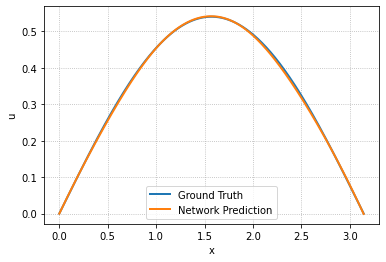

In [15]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [16]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.006660391227342188 %


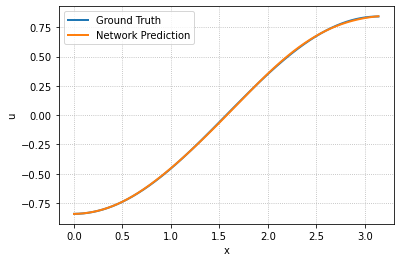

In [17]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [18]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.0031777890399098396 %


In [19]:
# for ploting

In [20]:
model = my_network
x_test = pi*torch.rand(100000).reshape(-1,1)
t_test = torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test,t_test).reshape(-1,1)
p_test = exact_solution_p(x_test,t_test).reshape(-1,1)
u_test_pred = my_network(test)
u_pred = u_test_pred[:, 0].reshape(-1,1)

u_pred1 = u_test_pred[:, 1].reshape(-1,1)


relative_error = torch.abs(u_pred- u_test)

relative_error1 = torch.abs(u_pred1- p_test)
u_pred = u_pred.detach().numpy()
x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
p_pred = u_pred1.detach().numpy()
relative_error = relative_error.detach().numpy()
relative_error1 = relative_error1.detach().numpy()

In [21]:

x_test = x_test.reshape(-1,)
t_test = t_test.reshape(-1,)

u_pred = u_pred.reshape(-1,)
p_pred = p_pred.reshape(-1,)

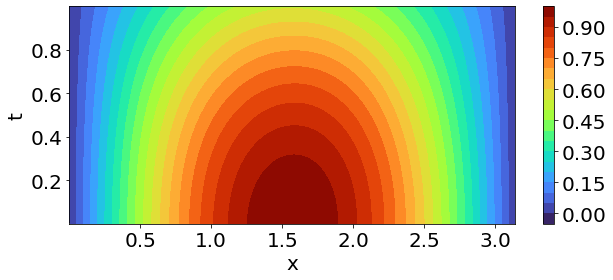

In [22]:

plt.rcParams['figure.figsize'] = [10, 4]


CS = plt.tricontourf(x_test, t_test, u_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#plt.savefig('timo_u.png', dpi = 300, bbox_inches = "tight")

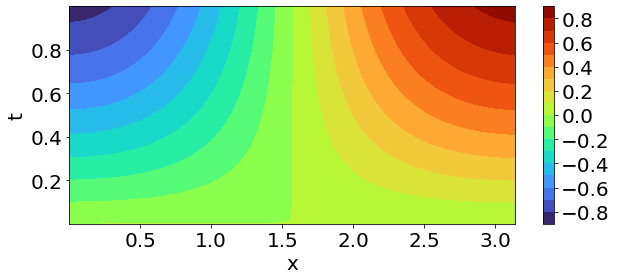

In [23]:
CS = plt.tricontourf(x_test, t_test, p_pred, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('timo_p.png', dpi = 300, bbox_inches = "tight")

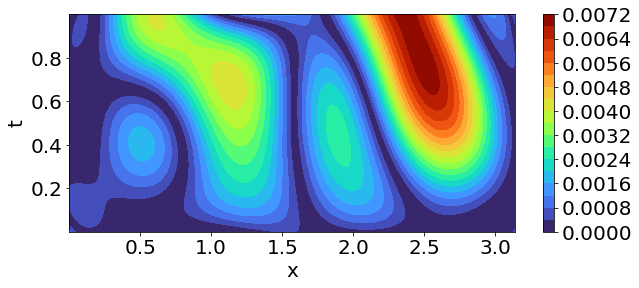

In [24]:

x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error = relative_error.reshape(-1,)




CS = plt.tricontourf(x_test, t_test, relative_error, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_u.png', dpi = 300, bbox_inches = "tight")

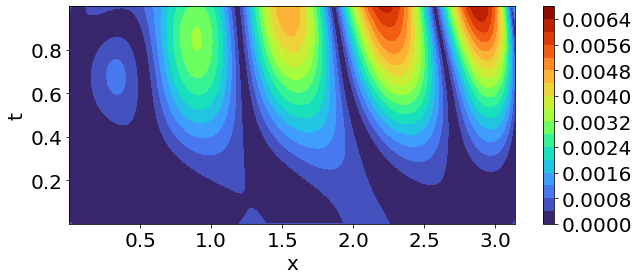

In [25]:



relative_error1 = relative_error1.reshape(-1,)

CS = plt.tricontourf(x_test, t_test, relative_error1, 20, cmap='turbo')


cbar = plt.colorbar(CS)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)


plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('relative_error_timo_p.png', dpi = 300, bbox_inches = "tight")